In [1]:
import os

import keras.src.utils
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


2025-03-30 10:19:38.831929: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 10:19:39.123217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743326379.219713    1865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743326379.246988    1865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743326379.471562    1865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
num_skipped = 0

for folder_name in ('Cat', 'Dog'):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, 'rb')
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()


        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)


print(f"Delete {num_skipped} files")

Delete 0 files


In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


I0000 00:00:1743326430.234540    1865 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2025-03-30 10:20:35.470389: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


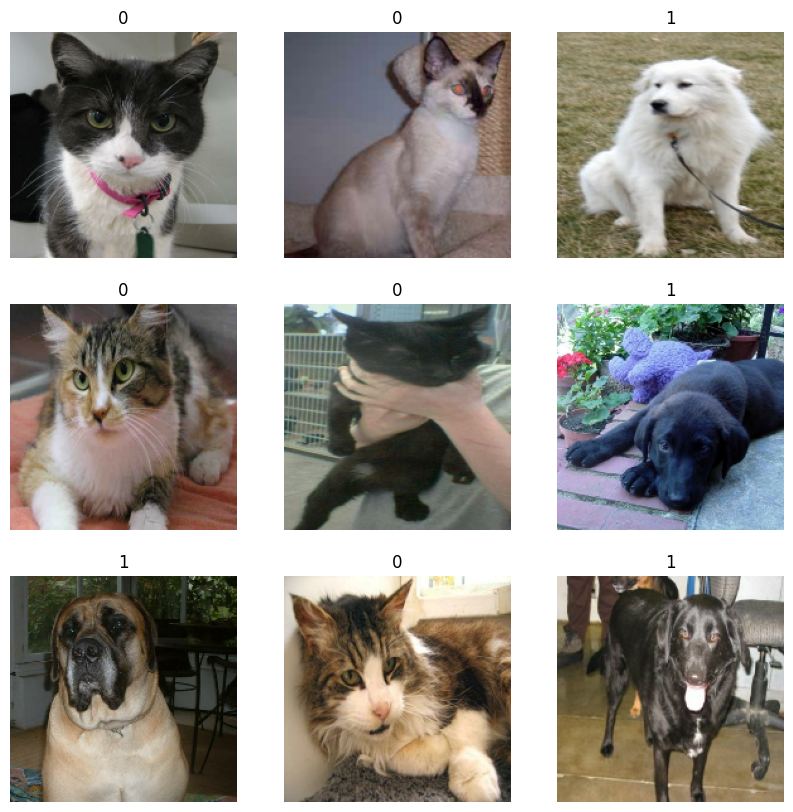

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(image):
    for layer in data_augmentation_layers:
        images = layer(image)
    return images


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2025-03-30 10:20:47.706472: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


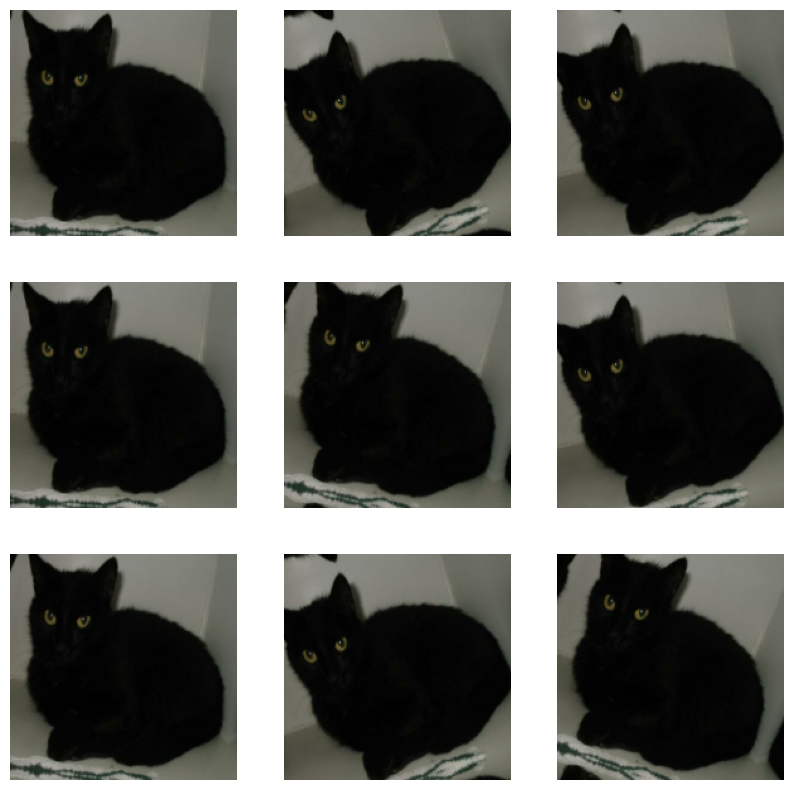

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
    for i in range(9):
        augmentation = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmentation[0]).astype("uint8"))
        plt.axis("off")

In [7]:
train_ds = train_ds.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activations = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(
            size, 1, strides=2, padding="same",
        ) (previous_block_activations)

        x = layers.add([x, residual])
        previous_block_activations = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        untis = 1
    else:
        untis = num_classes

    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(untis, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3, ), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("saved_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
this image is 4.57% cat and 95.43% dog


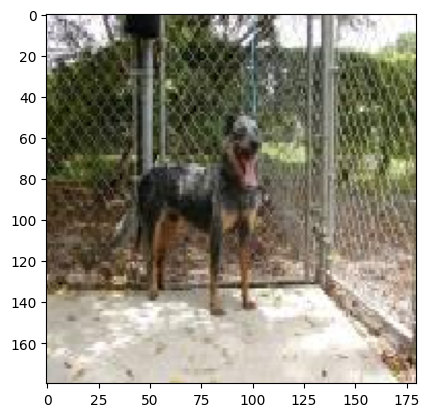

In [21]:
img = keras.utils.load_img("PetImages/Dog/6112.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))

print(f"this image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog")